# Model Training Pipeline - Home Credit Default Risk

This notebook trains multiple models with hyperparameter tuning and MLflow tracking:
- Logistic Regression (baseline)
- Random Forest
- XGBoost
- LightGBM

All experiments are logged to MLflow for comparison.

## 1. Setup and Imports

In [31]:
import sys
import os
import warnings
warnings.filterwarnings('ignore')

# Add src to path
sys.path.append('../src')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sklearn

from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb

import mlflow
import mlflow.sklearn
import mlflow.xgboost
import mlflow.lightgbm

# Import custom modules
from model_utils import *
from metrics import *

import joblib
from datetime import datetime

print("All imports successful!")
print(f"Pandas version: {pd.__version__}")
print(f"Scikit-learn version: {sklearn.__version__}")
print(f"XGBoost version: {xgb.__version__}")
print(f"LightGBM version: {lgb.__version__}")
print(f"MLflow version: {mlflow.__version__}")

All imports successful!
Pandas version: 2.3.3
Scikit-learn version: 1.7.2
XGBoost version: 3.1.2
LightGBM version: 4.6.0
MLflow version: 3.7.0


## 2. Configure MLflow

In [32]:
# Set MLflow tracking URI
mlflow.set_tracking_uri("http://127.0.0.1:5000")

# Create or set experiment
experiment_name = "home_credit_default_risk"
try:
    experiment_id = mlflow.create_experiment(experiment_name)
except:
    experiment_id = mlflow.get_experiment_by_name(experiment_name).experiment_id

mlflow.set_experiment(experiment_name)

print(f"MLflow Experiment: {experiment_name}")
print(f"Experiment ID: {experiment_id}")
print(f"Tracking URI: {mlflow.get_tracking_uri()}")

MLflow Experiment: home_credit_default_risk
Experiment ID: 1
Tracking URI: http://127.0.0.1:5000


## 3. Load Prepared Data

In [33]:
# Load the prepared data from notebook 01
df = pd.read_csv('../data/application_train_prepared.csv')

print(f"Data shape: {df.shape}")
print(f"\nColumns: {df.shape[1]}")
print(f"Rows: {df.shape[0]:,}")
print(f"\nMemory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

Data shape: (307511, 336)

Columns: 336
Rows: 307,511

Memory usage: 788.30 MB


## 4. Check Class Imbalance

Target column: TARGET

Class distribution:
TARGET
0    282686
1     24825
Name: count, dtype: int64

Class proportions:
TARGET
0    0.919271
1    0.080729
Name: proportion, dtype: float64


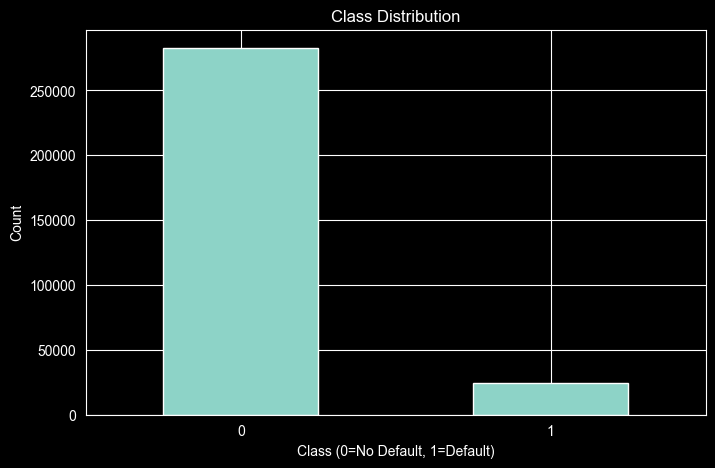


Scale pos weight (for XGBoost): 11.39


In [34]:
# Check target distribution
if 'TARGET' in df.columns:
    target_col = 'TARGET'
else:
    # Try to find target column
    target_col = [col for col in df.columns if 'target' in col.lower()][0]

print(f"Target column: {target_col}")
print(f"\nClass distribution:")
print(df[target_col].value_counts())
print(f"\nClass proportions:")
print(df[target_col].value_counts(normalize=True))

# Visualize
plt.figure(figsize=(8, 5))
df[target_col].value_counts().plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Class (0=No Default, 1=Default)')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

# Calculate imbalance ratio for scale_pos_weight
n_neg = (df[target_col] == 0).sum()
n_pos = (df[target_col] == 1).sum()
scale_pos_weight = n_neg / n_pos
print(f"\nScale pos weight (for XGBoost): {scale_pos_weight:.2f}")

## 5. Separate Features and Target

In [35]:
# Separate features and target
X = df.drop(columns=[target_col])
y = df[target_col]

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nFeature columns: {list(X.columns[:10])}...")

Features shape: (307511, 335)
Target shape: (307511,)

Feature columns: ['SK_ID_CURR', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE']...


## 6. Train/Test Split

In [36]:
# Stratified split to maintain class proportions
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

print(f"Training set size: {X_train.shape[0]:,}")
print(f"Test set size: {X_test.shape[0]:,}")
print(f"\nTraining class distribution:")
print(y_train.value_counts(normalize=True))
print(f"\nTest class distribution:")
print(y_test.value_counts(normalize=True))

Training set size: 246,008
Test set size: 61,503

Training class distribution:
TARGET
0    0.919271
1    0.080729
Name: proportion, dtype: float64

Test class distribution:
TARGET
0    0.919272
1    0.080728
Name: proportion, dtype: float64


## 7. Feature Scaling

In [37]:
# Scale features for models that need it (Logistic Regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Save scaler for production
os.makedirs('../models', exist_ok=True)
joblib.dump(scaler, '../models/scaler.pkl')
print("Scaler saved to ../models/scaler.pkl")

# Convert back to DataFrame for convenience
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print(f"Scaled training data shape: {X_train_scaled.shape}")

Scaler saved to ../models/scaler.pkl
Scaled training data shape: (246008, 335)


## 8. Helper Functions for Model Training

In [38]:

def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    """
    Evaluate model and return metrics
    """
    # Predictions
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    results = calculate_all_metrics(y_test, y_pred_proba)
    
    # Optimize threshold
    optimal_threshold = optimize_threshold(
        y_test, 
        y_pred_proba, 
        metric='business_cost',
        fn_cost=1,
        fp_cost=10
    )
    
    y_pred_optimal = (y_pred_proba >= optimal_threshold).astype(int)
    business_cost = calculate_business_cost(y_test, y_pred_optimal, fn_cost=1, fp_cost=10)
    
    print(f"\n{'='*60}")
    print(f"{model_name} Results")
    print(f"{'='*60}")
    print(f"AUC: {results['auc']:.4f}")
    print(f"Accuracy: {results['accuracy']:.4f}")
    print(f"Precision: {results['precision']:.4f}")
    print(f"Recall: {results['recall']:.4f}")
    print(f"F1-Score: {results['f1']:.4f}")
    print(f"Optimal Threshold: {optimal_threshold:.4f}")
    print(f"Business Cost (with optimal threshold): {business_cost:.2f}")
    
    return {
        **results,
        'optimal_threshold': optimal_threshold,
        'business_cost_optimal': business_cost
    }

## 9. Baseline: Logistic Regression

### 9.1 Configure and Train

In [39]:
print("Training Logistic Regression (Baseline)...\n")

# Configure model
lr_params = {
    'solver': 'lbfgs',
    'max_iter': 1000,
    'class_weight': 'balanced',
    'random_state': 42,
    'n_jobs': -1
}

lr_model = LogisticRegression(**lr_params)

# Train with cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(lr_model, X_train_scaled, y_train, cv=skf, scoring='roc_auc', n_jobs=-1)

print(f"Cross-validation AUC scores: {cv_scores}")
print(f"Mean CV AUC: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# Train final model
lr_model.fit(X_train_scaled, y_train)

Training Logistic Regression (Baseline)...

Cross-validation AUC scores: [0.76199776 0.76379962 0.7707779  0.76589342 0.7662803 ]
Mean CV AUC: 0.7657 (+/- 0.0059)


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,42
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


### 9.2 Evaluate and Log to MLflow

In [40]:
# Evaluate
lr_metrics = evaluate_model(lr_model, X_train_scaled, X_test_scaled, y_train, y_test, "Logistic Regression")

# Log to MLflow
with mlflow.start_run(run_name="logistic_regression_baseline"):
    # Log parameters
    mlflow.log_params(lr_params)
    mlflow.log_param("cv_folds", 5)
    
    # Log metrics
    mlflow.log_metric("cv_auc_mean", cv_scores.mean())
    mlflow.log_metric("cv_auc_std", cv_scores.std())
    mlflow.log_metrics({
        "test_auc": lr_metrics['auc'],
        "test_accuracy": lr_metrics['accuracy'],
        "test_precision": lr_metrics['precision'],
        "test_recall": lr_metrics['recall'],
        "test_f1": lr_metrics['f1'],
        "optimal_threshold": lr_metrics['optimal_threshold'],
        "business_cost": lr_metrics['business_cost_optimal']
    })
    
    # Log model
    mlflow.sklearn.log_model(lr_model, "model", input_example=X_train_scaled[:5])
    
    print("\nLogged to MLflow successfully!")


Logistic Regression Results
AUC: 0.7684
Accuracy: 0.7039
Precision: 0.1710
Recall: 0.6931
F1-Score: 0.2743
Optimal Threshold: 1.0000
Business Cost (with optimal threshold): 4965.00


2025/12/09 11:19:31 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



Logged to MLflow successfully!
🏃 View run logistic_regression_baseline at: http://127.0.0.1:5000/#/experiments/1/runs/17c3dd373d0f465c91c001cfb780e71e
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1


### 9.3 Feature Importance


Top 20 Most Important Features (Logistic Regression):
                            feature  coefficient
293       INSTAL_AMT_INSTALMENT_STD    -1.007967
298          INSTAL_AMT_PAYMENT_STD     0.959255
9                   AMT_GOODS_PRICE    -0.916989
7                        AMT_CREDIT     0.888789
297          INSTAL_AMT_PAYMENT_SUM    -0.773982
311          POS_CNT_INSTALMENT_MAX     0.666297
292       INSTAL_AMT_INSTALMENT_SUM     0.657364
289      INSTAL_AMT_INSTALMENT_MEAN     0.600781
294         INSTAL_AMT_PAYMENT_MEAN    -0.560991
316   POS_CNT_INSTALMENT_FUTURE_MAX    -0.524068
144  BUREAU_AMT_CREDIT_SUM_DEBT_MAX    -0.471623
61                BASEMENTAREA_MEDI     0.416244
43                 BASEMENTAREA_AVG    -0.405508
326              POS_SK_DPD_DEF_MAX     0.405244
41                     EXT_SOURCE_3    -0.394723
310         POS_CNT_INSTALMENT_MEAN    -0.384122
40                     EXT_SOURCE_2    -0.378872
105         BUREAU_SK_ID_BUREAU_MAX     0.365064
315  POS_CNT_I

<Figure size 1000x800 with 0 Axes>

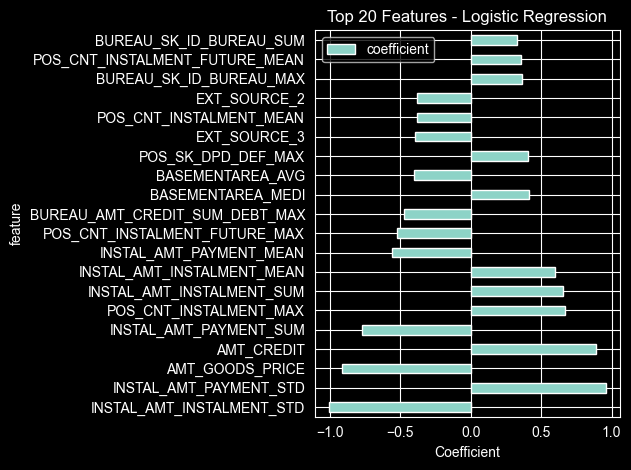

In [41]:
# Get feature importance (coefficients)
feature_importance_lr = pd.DataFrame({
    'feature': X_train.columns,
    'coefficient': lr_model.coef_[0]
}).sort_values('coefficient', key=abs, ascending=False)

print("\nTop 20 Most Important Features (Logistic Regression):")
print(feature_importance_lr.head(20))

# Visualize
plt.figure(figsize=(10, 8))
feature_importance_lr.head(20).plot(x='feature', y='coefficient', kind='barh')
plt.title('Top 20 Features - Logistic Regression')
plt.xlabel('Coefficient')
plt.tight_layout()
plt.show()

### 9.4 Save Model

In [42]:
# Save model
joblib.dump(lr_model, '../models/logistic_regression.pkl')
print("Model saved to ../models/logistic_regression.pkl")

Model saved to ../models/logistic_regression.pkl


## 10. Random Forest

### 10.1 Hyperparameter Tuning

In [43]:
print("Training Random Forest with RandomizedSearchCV...\n")

# Define parameter grid
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': ['balanced'],
    'random_state': [42],
    'n_jobs': [-1]
}

# RandomizedSearchCV
rf_base = RandomForestClassifier()
rf_random = RandomizedSearchCV(
    rf_base,
    rf_param_grid,
    n_iter=2,
    cv=3,
    scoring='roc_auc',
    n_jobs=-1,
    random_state=42,
    verbose=2
)

# Fit (use non-scaled data for tree-based models)
rf_random.fit(X_train, y_train)

print(f"\nBest parameters: {rf_random.best_params_}")
print(f"Best CV AUC: {rf_random.best_score_:.4f}")

Training Random Forest with RandomizedSearchCV...

Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV] END class_weight=balanced, max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=200, n_jobs=-1, random_state=42; total time= 1.7min
[CV] END class_weight=balanced, max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=200, n_jobs=-1, random_state=42; total time= 1.8min
[CV] END class_weight=balanced, max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=200, n_jobs=-1, random_state=42; total time= 1.8min
[CV] END class_weight=balanced, max_depth=30, min_samples_leaf=4, min_samples_split=5, n_estimators=300, n_jobs=-1, random_state=42; total time= 3.0min
[CV] END class_weight=balanced, max_depth=30, min_samples_leaf=4, min_samples_split=5, n_estimators=300, n_jobs=-1, random_state=42; total time= 3.0min
[CV] END class_weight=balanced, max_depth=30, min_samples_leaf=4, min_samples_split=5, n_estimators=300, n_jobs=-1, random_state=4

### 10.2 Train Final Model with Best Parameters

In [44]:
# Train final model with best params and 5-fold CV
rf_model = RandomForestClassifier(**rf_random.best_params_)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores_rf = cross_val_score(rf_model, X_train, y_train, cv=skf, scoring='roc_auc', n_jobs=-1)

print(f"\n5-Fold CV AUC scores: {cv_scores_rf}")
print(f"Mean CV AUC: {cv_scores_rf.mean():.4f} (+/- {cv_scores_rf.std() * 2:.4f})")

# Train final model
rf_model.fit(X_train, y_train)


5-Fold CV AUC scores: [0.74949747 0.74966051 0.75459406 0.75271816 0.74898008]
Mean CV AUC: 0.7511 (+/- 0.0044)


,n_estimators,300
,criterion,'gini'
,max_depth,30
,min_samples_split,5
,min_samples_leaf,4
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


### 10.3 Evaluate and Log to MLflow

In [45]:
# Evaluate
rf_metrics = evaluate_model(rf_model, X_train, X_test, y_train, y_test, "Random Forest")

# Log to MLflow
with mlflow.start_run(run_name="random_forest_tuned"):
    # Log parameters
    mlflow.log_params(rf_random.best_params_)
    mlflow.log_param("cv_folds", 5)
    mlflow.log_param("n_iter_random_search", 20)
    
    # Log metrics
    mlflow.log_metric("cv_auc_mean", cv_scores_rf.mean())
    mlflow.log_metric("cv_auc_std", cv_scores_rf.std())
    mlflow.log_metrics({
        "test_auc": rf_metrics['auc'],
        "test_accuracy": rf_metrics['accuracy'],
        "test_precision": rf_metrics['precision'],
        "test_recall": rf_metrics['recall'],
        "test_f1": rf_metrics['f1'],
        "optimal_threshold": rf_metrics['optimal_threshold'],
        "business_cost": rf_metrics['business_cost_optimal']
    })
    
    # Log model
    mlflow.sklearn.log_model(rf_model, "model", input_example=X_train[:5])
    
    print("\nLogged to MLflow successfully!")

2025/12/09 11:29:16 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



Random Forest Results
AUC: 0.7553
Accuracy: 0.9178
Precision: 0.4128
Recall: 0.0443
F1-Score: 0.0800
Optimal Threshold: 0.7778
Business Cost (with optimal threshold): 4964.00

Logged to MLflow successfully!
🏃 View run random_forest_tuned at: http://127.0.0.1:5000/#/experiments/1/runs/f058fcb6c18a4e84b260c2810297075c
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1


### 10.4 Feature Importance


Top 20 Most Important Features (Random Forest):
                             feature  importance
40                      EXT_SOURCE_2    0.038673
41                      EXT_SOURCE_3    0.032197
39                      EXT_SOURCE_1    0.015390
333                        AGE_YEARS    0.010662
16                        DAYS_BIRTH    0.010308
296           INSTAL_AMT_PAYMENT_MIN    0.009552
109          BUREAU_DAYS_CREDIT_MEAN    0.009224
17                     DAYS_EMPLOYED    0.008407
334                   YEARS_EMPLOYED    0.008361
110           BUREAU_DAYS_CREDIT_MAX    0.008060
8                        AMT_ANNUITY    0.007115
9                    AMT_GOODS_PRICE    0.006979
7                         AMT_CREDIT    0.006867
19                   DAYS_ID_PUBLISH    0.006863
18                 DAYS_REGISTRATION    0.006695
331              CREDIT_INCOME_RATIO    0.006659
332             ANNUITY_INCOME_RATIO    0.006533
158   BUREAU_DAYS_CREDIT_UPDATE_MEAN    0.006432
119  BUREAU_DAYS_CRE

<Figure size 1000x800 with 0 Axes>

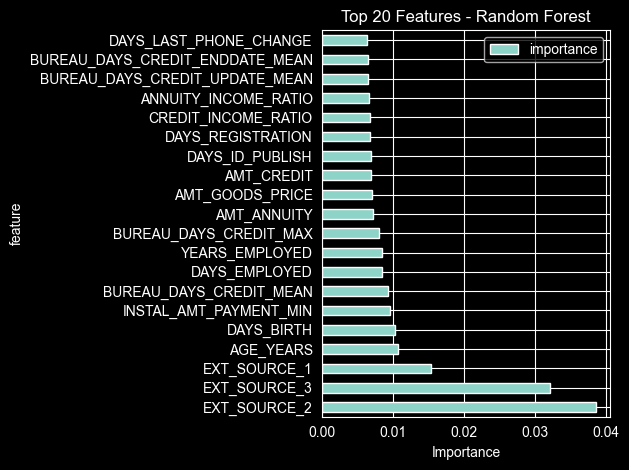

In [46]:
# Get feature importance
feature_importance_rf = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 20 Most Important Features (Random Forest):")
print(feature_importance_rf.head(20))

# Visualize
plt.figure(figsize=(10, 8))
feature_importance_rf.head(20).plot(x='feature', y='importance', kind='barh')
plt.title('Top 20 Features - Random Forest')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

### 10.5 Save Model

In [47]:
# Save model
joblib.dump(rf_model, '../models/random_forest.pkl')
print("Model saved to ../models/random_forest.pkl")

Model saved to ../models/random_forest.pkl


## 11. XGBoost

### 11.1 Hyperparameter Tuning

In [ ]:
print("Training XGBoost with RandomizedSearchCV...\n")

# Define parameter grid
xgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'scale_pos_weight': [scale_pos_weight],
    'random_state': [42],
    'n_jobs': [-1]
}

# RandomizedSearchCV
xgb_base = xgb.XGBClassifier()
xgb_random = RandomizedSearchCV(
    xgb_base,
    xgb_param_grid,
    n_iter=20,
    cv=3,
    scoring='roc_auc',
    n_jobs=-1,
    random_state=42,
    verbose=2
)

# Fit
xgb_random.fit(X_train, y_train)

print(f"\nBest parameters: {xgb_random.best_params_}")
print(f"Best CV AUC: {xgb_random.best_score_:.4f}")

Training XGBoost with RandomizedSearchCV...

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, n_jobs=-1, random_state=42, scale_pos_weight=11.387150050352467, subsample=0.6; total time=  15.5s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, n_jobs=-1, random_state=42, scale_pos_weight=11.387150050352467, subsample=0.6; total time=  14.4s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, n_jobs=-1, random_state=42, scale_pos_weight=11.387150050352467, subsample=0.6; total time=  14.6s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=5, n_estimators=100, n_jobs=-1, random_state=42, scale_pos_weight=11.387150050352467, subsample=0.6; total time=  18.6s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=5, n_estimators=100, n_jobs=-1, random_state=42, scale_pos_weight=11.387150050352467, subsample=0.6; total ti

### 11.2 Train Final Model with Best Parameters

In [ ]:
# Train final model with best params and 5-fold CV
xgb_model = xgb.XGBClassifier(**xgb_random.best_params_)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores_xgb = cross_val_score(xgb_model, X_train, y_train, cv=skf, scoring='roc_auc', n_jobs=-1)

print(f"\n5-Fold CV AUC scores: {cv_scores_xgb}")
print(f"Mean CV AUC: {cv_scores_xgb.mean():.4f} (+/- {cv_scores_xgb.std() * 2:.4f})")

# Train final model
xgb_model.fit(X_train, y_train)

### 11.3 Evaluate and Log to MLflow

In [ ]:
# Evaluate
xgb_metrics = evaluate_model(xgb_model, X_train, X_test, y_train, y_test, "XGBoost")

# Log to MLflow
with mlflow.start_run(run_name="xgboost_tuned"):
    # Log parameters
    mlflow.log_params(xgb_random.best_params_)
    mlflow.log_param("cv_folds", 5)
    mlflow.log_param("n_iter_random_search", 20)
    
    # Log metrics
    mlflow.log_metric("cv_auc_mean", cv_scores_xgb.mean())
    mlflow.log_metric("cv_auc_std", cv_scores_xgb.std())
    mlflow.log_metrics({
        "test_auc": xgb_metrics['auc'],
        "test_accuracy": xgb_metrics['accuracy'],
        "test_precision": xgb_metrics['precision'],
        "test_recall": xgb_metrics['recall'],
        "test_f1": xgb_metrics['f1'],
        "optimal_threshold": xgb_metrics['optimal_threshold'],
        "business_cost": xgb_metrics['business_cost_optimal']
    })
    
    # Log model
    mlflow.xgboost.log_model(xgb_model, "model", input_example=X_train[:5])
    
    print("\nLogged to MLflow successfully!")

### 11.4 Feature Importance

In [ ]:
# Get feature importance (gain)
feature_importance_xgb = pd.DataFrame({
    'feature': X_train.columns,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 20 Most Important Features (XGBoost):")
print(feature_importance_xgb.head(20))

# Visualize
plt.figure(figsize=(10, 8))
feature_importance_xgb.head(20).plot(x='feature', y='importance', kind='barh')
plt.title('Top 20 Features - XGBoost')
plt.xlabel('Importance (Gain)')
plt.tight_layout()
plt.show()

### 11.5 Save Model

In [ ]:
# Save model
joblib.dump(xgb_model, '../models/xgboost.pkl')
print("Model saved to ../models/xgboost.pkl")

## 12. LightGBM

### 12.1 Hyperparameter Tuning

In [ ]:
print("Training LightGBM with RandomizedSearchCV...\n")

# Define parameter grid
lgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15, -1],
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [31, 50, 100],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'class_weight': ['balanced'],
    'random_state': [42],
    'n_jobs': [-1]
}

# RandomizedSearchCV
lgb_base = lgb.LGBMClassifier()
lgb_random = RandomizedSearchCV(
    lgb_base,
    lgb_param_grid,
    n_iter=20,
    cv=3,
    scoring='roc_auc',
    n_jobs=-1,
    random_state=42,
    verbose=2
)

# Fit
lgb_random.fit(X_train, y_train)

print(f"\nBest parameters: {lgb_random.best_params_}")
print(f"Best CV AUC: {lgb_random.best_score_:.4f}")

### 12.2 Train Final Model with Best Parameters

In [ ]:
# Train final model with best params and 5-fold CV
lgb_model = lgb.LGBMClassifier(**lgb_random.best_params_)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores_lgb = cross_val_score(lgb_model, X_train, y_train, cv=skf, scoring='roc_auc', n_jobs=-1)

print(f"\n5-Fold CV AUC scores: {cv_scores_lgb}")
print(f"Mean CV AUC: {cv_scores_lgb.mean():.4f} (+/- {cv_scores_lgb.std() * 2:.4f})")

# Train final model
lgb_model.fit(X_train, y_train)

### 12.3 Evaluate and Log to MLflow

In [ ]:
# Evaluate
lgb_metrics = evaluate_model(lgb_model, X_train, X_test, y_train, y_test, "LightGBM")

# Log to MLflow
with mlflow.start_run(run_name="lightgbm_tuned"):
    # Log parameters
    mlflow.log_params(lgb_random.best_params_)
    mlflow.log_param("cv_folds", 5)
    mlflow.log_param("n_iter_random_search", 20)
    
    # Log metrics
    mlflow.log_metric("cv_auc_mean", cv_scores_lgb.mean())
    mlflow.log_metric("cv_auc_std", cv_scores_lgb.std())
    mlflow.log_metrics({
        "test_auc": lgb_metrics['auc'],
        "test_accuracy": lgb_metrics['accuracy'],
        "test_precision": lgb_metrics['precision'],
        "test_recall": lgb_metrics['recall'],
        "test_f1": lgb_metrics['f1'],
        "optimal_threshold": lgb_metrics['optimal_threshold'],
        "business_cost": lgb_metrics['business_cost_optimal']
    })
    
    # Log model
    mlflow.lightgbm.log_model(lgb_model, "model", input_example=X_train[:5])
    
    print("\nLogged to MLflow successfully!")

### 12.4 Feature Importance

In [ ]:
# Get feature importance
feature_importance_lgb = pd.DataFrame({
    'feature': X_train.columns,
    'importance': lgb_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 20 Most Important Features (LightGBM):")
print(feature_importance_lgb.head(20))

# Visualize
plt.figure(figsize=(10, 8))
feature_importance_lgb.head(20).plot(x='feature', y='importance', kind='barh')
plt.title('Top 20 Features - LightGBM')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

### 12.5 Save Model

In [ ]:
# Save model
joblib.dump(lgb_model, '../models/lightgbm.pkl')
print("Model saved to ../models/lightgbm.pkl")

## 13. Model Comparison

### 13.1 Create Comparison Table

In [ ]:
# Compile all results
comparison_df = pd.DataFrame([
    {
        'Model': 'Logistic Regression',
        'AUC': lr_metrics['auc'],
        'Accuracy': lr_metrics['accuracy'],
        'Precision': lr_metrics['precision'],
        'Recall': lr_metrics['recall'],
        'F1-Score': lr_metrics['f1'],
        'Business Cost': lr_metrics['business_cost_optimal'],
        'Optimal Threshold': lr_metrics['optimal_threshold']
    },
    {
        'Model': 'Random Forest',
        'AUC': rf_metrics['auc'],
        'Accuracy': rf_metrics['accuracy'],
        'Precision': rf_metrics['precision'],
        'Recall': rf_metrics['recall'],
        'F1-Score': rf_metrics['f1'],
        'Business Cost': rf_metrics['business_cost_optimal'],
        'Optimal Threshold': rf_metrics['optimal_threshold']
    },
    {
        'Model': 'XGBoost',
        'AUC': xgb_metrics['auc'],
        'Accuracy': xgb_metrics['accuracy'],
        'Precision': xgb_metrics['precision'],
        'Recall': xgb_metrics['recall'],
        'F1-Score': xgb_metrics['f1'],
        'Business Cost': xgb_metrics['business_cost_optimal'],
        'Optimal Threshold': xgb_metrics['optimal_threshold']
    },
    {
        'Model': 'LightGBM',
        'AUC': lgb_metrics['auc'],
        'Accuracy': lgb_metrics['accuracy'],
        'Precision': lgb_metrics['precision'],
        'Recall': lgb_metrics['recall'],
        'F1-Score': lgb_metrics['f1'],
        'Business Cost': lgb_metrics['business_cost_optimal'],
        'Optimal Threshold': lgb_metrics['optimal_threshold']
    }
])

print("\n" + "="*80)
print("MODEL COMPARISON")
print("="*80)
print(comparison_df.to_string(index=False))
print("="*80)

### 13.2 Select Champion Model

In [ ]:
# Select best model based on business cost
best_model_idx = comparison_df['Business Cost'].idxmin()
best_model_name = comparison_df.loc[best_model_idx, 'Model']

print(f"\nCHAMPION MODEL: {best_model_name}")
print(f"Business Cost: {comparison_df.loc[best_model_idx, 'Business Cost']:.2f}")
print(f"AUC: {comparison_df.loc[best_model_idx, 'AUC']:.4f}")
print(f"Optimal Threshold: {comparison_df.loc[best_model_idx, 'Optimal Threshold']:.4f}")

### 13.3 Export Results to CSV

In [ ]:
# Save comparison results
os.makedirs('../reports', exist_ok=True)
comparison_df.to_csv('../reports/model_comparison.csv', index=False)
print("\nComparison results saved to ../reports/model_comparison.csv")

### 13.4 Visualize Comparison

In [ ]:
# Create comparison visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# AUC
axes[0, 0].barh(comparison_df['Model'], comparison_df['AUC'])
axes[0, 0].set_xlabel('AUC')
axes[0, 0].set_title('Model Comparison - AUC')
axes[0, 0].set_xlim([0.7, 0.8])

# F1-Score
axes[0, 1].barh(comparison_df['Model'], comparison_df['F1-Score'])
axes[0, 1].set_xlabel('F1-Score')
axes[0, 1].set_title('Model Comparison - F1-Score')

# Business Cost
axes[1, 0].barh(comparison_df['Model'], comparison_df['Business Cost'])
axes[1, 0].set_xlabel('Business Cost (Lower is Better)')
axes[1, 0].set_title('Model Comparison - Business Cost')
axes[1, 0].invert_xaxis()

# Recall
axes[1, 1].barh(comparison_df['Model'], comparison_df['Recall'])
axes[1, 1].set_xlabel('Recall')
axes[1, 1].set_title('Model Comparison - Recall')

plt.tight_layout()
os.makedirs('../reports/figures', exist_ok=True)
plt.savefig('../reports/figures/model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("Comparison plot saved to ../reports/figures/model_comparison.png")

### 13.5 Summary Statistics

In [ ]:
print("\n" + "="*80)
print("TRAINING SUMMARY")
print("="*80)
print(f"Total training samples: {X_train.shape[0]:,}")
print(f"Total test samples: {X_test.shape[0]:,}")
print(f"Number of features: {X_train.shape[1]:,}")
print(f"Class imbalance ratio: {scale_pos_weight:.2f}")
print(f"\nModels trained: 4")
print(f"Total MLflow runs: 4")
print(f"\nBest model: {best_model_name}")
print(f"Best business cost: {comparison_df.loc[best_model_idx, 'Business Cost']:.2f}")
print("="*80)

## Next Steps

1. **View MLflow UI**: Run `mlflow ui --backend-store-uri file:../mlruns` in terminal
2. **Register Champion Model**: Register the best model in MLflow Model Registry
3. **Explainability Analysis**: Run notebook `03_explainability.ipynb` to generate SHAP explanations
4. **Model Serving**: Run notebook `04_mlflow_serving_test.ipynb` to test deployment